In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [2]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)
Date3 = np.load("training_sets/Date3.npy", allow_pickle = True)

In [3]:
Datesog = np.append(np.append(Date1, Date2), Date3)

In [4]:
np.where(Datesog == "2017-11-10")[0][0]

1456

In [26]:
df = pd.read_pickle("CreatingSecondDataset/train_df")

In [27]:
df2 = pd.read_pickle("CreatingSecondDataset/train_df_2")

In [28]:
Dates = np.sort(np.unique(df.reset_index().set_index(["Date"]).index))

In [29]:
df = df.loc[Dates]

In [30]:
df = df.append(df2)

In [36]:
df

Close  ABAND_indicator_10  ABAND_indicator_20  \
Date       Ticker                                                  
2014-04-28 ISR      2.04           -0.330088           -0.433578   
           ALNY    48.87           -0.254625           -0.433430   
           PTE     16.59           -0.091001           -0.065728   
           RIOT    16.64           -0.126365           -0.211106   
           AVEO    12.40           -0.253859           -0.412510   
...                  ...                 ...                 ...   
2021-06-24 BHR      6.07           -0.185533           -0.142151   
           CPS     28.59           -0.259606           -0.297265   
           CSU     43.96           -0.043801           -0.052232   
           WATT     2.89           -0.001275           -0.037216   
           LPTH     2.62            0.010391           -0.024054   

                   ABAND_indicator_40  ABAND_signal_10  ABAND_signal_20  \
Date       Ticker                                                         
2014-04-28 ISR              -0.073089              0.0             -1.0   
           ALNY             -0.772110              0.0             -1.0   
           PTE              -0.327272              0.0              0.0   
           RIOT             -0.489782              0.0              0.0   
           AVEO             -0.788249              0.0             -1.0   
...                               ...              ...              ...   
2021-06-24 BHR              -0.135235              0.0              0.0   
           CPS              -0.203730              0.0              0.0   
           CSU              -0.173040              0.0              0.0   
           WATT              0.067659              0.0              0.0   
           LPTH              0.044828              0.0              0.0   

                   ABAND_signal_40  MFV_40_10_indicator_sign_change  \
Date       Ticker                                                     
2014-04-28 ISR                 0.0                              0.0   
           ALNY               -1.0                              0.0   
           PTE                 0.0                              0.0   
           RIOT               -1.0                              0.0   
           AVEO               -1.0                              0.0   
...                            ...                              ...   
2021-06-24 BHR                 0.0                              0.0   
           CPS                 0.0                              0.0   
           CSU                 0.0                              0.0   
           WATT                0.0                              0.0   
           LPTH                0.0                              0.0   

                   APO_10_20  APO_10_40  ...  return_40  Class_multi_40_20  \
Date       Ticker                        ...                                 
2014-04-28 ISR     -0.011892   0.111151  ...  45.588235                0.0   
           ALNY    -0.065416  -0.146319  ...  35.604665                0.0   
           PTE     -0.023115  -0.086733  ... -36.347197               19.0   
           RIOT    -0.038634  -0.082976  ...   9.134615                5.0   
           AVEO    -0.050611  -0.119489  ...  27.016129                1.0   
...                      ...        ...  ...        ...                ...   
2021-06-24 BHR     -0.003960  -0.004792  ... -21.416804               16.0   
           CPS     -0.015965  -0.037503  ... -21.895768               16.0   
           CSU     -0.010579  -0.003391  ... -25.159236               17.0   
           WATT     0.001484  -0.022629  ... -22.837370               17.0   
           LPTH     0.001670  -0.017187  ... -29.389313               18.0   

                   Class_binary_20_20  return_20  Class_binary_10_20  \
Date       Ticker                                                      
2014-04-28 ISR                    1.0  10.294118                 0.0   
   

In [32]:
Dates = np.sort(np.unique(df.reset_index().set_index(["Date"]).index))

In [33]:
Dates = np.unique(Dates)

In [34]:
df = df.loc[Dates]

In [35]:
del df2

In [15]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col, return_col, return_col_2):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(cols, [return_col, return_col_2])])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_return_40 = X_test.pop(return_col)
    
    Class_multi_40_20_test = X_test.pop(return_col_2)
    
    return X_train, X_test, Y_train, Y_return_40, Class_multi_40_20_test

In [16]:
def return_40_metric(pred, labels, scale, labels_multi):
    
    a = labels.iloc[np.argsort(pred)[:int(len(pred) * (1 / (scale + 1)))]].values
    
    b = labels_multi.iloc[np.argsort(pred)[:int(len(pred) * (1 / (scale + 1)))]].values
    
    
    val = ((b== 0).sum() + (b == 1).sum() + (b == 2).sum() + (b == 3).sum()) / ((b== 19).sum() + (b == 18).sum() + (b == 17).sum() + (b == 16).sum())
    
    
    return np.mean(a), val

In [17]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval, scale, labels_multi):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        self.scale = scale
        self.labels_multi = labels_multi
        
    def after_iteration(self, model, epoch, evals_log):
        
        
        if epoch % 5 == 0 or epoch == 59:
            

            self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40, self.scale, self.labels_multi))    
        

            
        return False

In [18]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [ ]:
with open("TrainingSecondDataset/highest_return_binary_20_2", "rb") as f:
    results = pickle.load(f)

In [ ]:
with open("TrainingSecondDataset/highest_return_binary_20_3", "rb") as f:
    results = pickle.load(f)

In [18]:
df.columns[:-11]

Index(['Close', 'ABAND_indicator_10', 'ABAND_indicator_20',
       'ABAND_indicator_40', 'ABAND_signal_10', 'ABAND_signal_20',
       'ABAND_signal_40', 'MFV_40_10_indicator_sign_change', 'APO_10_20',
       'APO_10_40',
       ...
       'Return on Equity_QC', 'Return on Equity_YC', 'Current Ratio',
       'Current Ratio_QC', 'Current Ratio_YC',
       'Selling, General & Administrative/Total Cost',
       'Property, Plant & Equipment, Net',
       'Property, Plant & Equipment, Net_QC',
       'Property, Plant & Equipment, Net_YC',
       'Property, Plant & Equipment, Net/Total Cost'],
      dtype='object', length=290)

In [20]:
count = 0
start_time = time.perf_counter()
start_time_save = time.perf_counter()
results = []

while True:
    
    results1 = []
        
    count += 1
    
    t = time.localtime()
    
    current_time = time.strftime("%H:%M:%S", t)


    print(str(count) +"     "+ current_time)
    
    if count > 0 and time.perf_counter()  - start_time > 3600:
        
        print("sleeping")
        
        time.sleep(600)
        
        start_time = time.perf_counter()
        
        

    pred_date_indx = np.random.randint(91, len(Dates) - 22)

    prediction_period = Dates[pred_date_indx: pred_date_indx + 20]

    pred_date_indx_datesog = np.where(Datesog == prediction_period[0])[0][0]

    last_possible_train_date = Datesog[pred_date_indx_datesog - 41]
    
    training_period = Dates[Dates <= last_possible_train_date]



    cols = np.random.choice(df.columns[:-11], np.random.randint(7, 25), replace = "False")
    
    cols = np.unique(cols)
    


    X_train, X_test, Y_train, Y_return_40, Class_multi_40_20_test = make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, "Class_binary_40_20", "return_40", "Class_multi_40_20")
    
    
    scale = int(np.sum(Y_train == 1) / np.sum(Y_train == 0))
    
    train_weights = Y_train.map({0:scale, 1:1})
    

    xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)

    xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)

    data = []

    mycallback = my_callback(xgtest, Y_return_40, data, scale, Class_multi_40_20_test)

    bst = xgboost.train(params1, xgtrain, num_boost_round = 60, verbose_eval = False, callbacks = [mycallback])


    results1.append(prediction_period[0])
    results1.append(cols)
    results1.append(len(X_train))
    results1.append(len(X_test))
    results1.append(data)

    results.append(results1)
    
    
    if time.perf_counter() - start_time_save > 300:
        
        with open("TrainingSecondDataset/highest_return_binary_20_4", "wb") as f:
            pickle.dump(results, f)
            
        start_time_save = time.perf_counter()

    







1     02:38:29
2     02:38:39
3     02:38:49
4     02:39:00
5     02:39:10
6     02:39:20
7     02:39:31
8     02:39:42
9     02:39:52
10     02:40:02
11     02:40:13
12     02:40:24
13     02:40:34
14     02:40:43
15     02:40:55
16     02:41:06
17     02:41:16
18     02:41:27
19     02:41:37
20     02:41:48
21     02:41:58
22     02:42:08
23     02:42:18
24     02:42:28
25     02:42:38
26     02:42:48
27     02:42:58
28     02:43:09
29     02:43:20
30     02:43:31
31     02:43:43
32     02:43:53
33     02:44:05
34     02:44:16
35     02:44:27
36     02:44:38
37     02:44:49
38     02:45:00
39     02:45:11
40     02:45:22
41     02:45:33
42     02:45:44
43     02:45:55
44     02:46:06
45     02:46:17
46     02:46:28
47     02:46:39
48     02:46:50
49     02:47:01
50     02:47:13
51     02:47:23
52     02:47:34
53     02:47:45
54     02:47:56
55     02:48:07
56     02:48:18
57     02:48:29
58     02:48:40
59     02:48:51
60     02:49:03
61     02:49:14
62     02:49:27
63     02:49:37
6

C:\Users\Chirag\AppData\Local\Temp/ipykernel_10404/3946219388.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  val = ((b== 0).sum() + (b == 1).sum() + (b == 2).sum() + (b == 3).sum()) / ((b== 19).sum() + (b == 18).sum() + (b == 17).sum() + (b == 16).sum())


454     04:16:17
455     04:16:29
456     04:16:41
457     04:16:54
458     04:17:05
459     04:17:17
460     04:17:29
461     04:17:41
462     04:17:53
463     04:18:05
464     04:18:17
465     04:18:29
466     04:18:41
467     04:18:53
468     04:19:05
469     04:19:16
470     04:19:28
471     04:19:40
472     04:19:51
473     04:20:02
474     04:20:14
475     04:20:27
476     04:20:39
477     04:20:50
478     04:21:02
479     04:21:14
480     04:21:26
481     04:21:38
482     04:21:49
483     04:22:01
484     04:22:13
485     04:22:25
486     04:22:36
487     04:22:48
488     04:23:00
489     04:23:13
490     04:23:24
491     04:23:36
492     04:23:47
493     04:24:00
494     04:24:12
495     04:24:23
496     04:24:35
497     04:24:47
498     04:24:59
499     04:25:11
500     04:25:23
501     04:25:35
502     04:25:46
503     04:25:58
504     04:26:10
505     04:26:22
506     04:26:35
507     04:26:47
508     04:26:59
509     04:27:10
510     04:27:23
511     04:27:35
512     04:27:

KeyboardInterrupt: 

In [22]:
with open("TrainingSecondDataset/highest_return_binary_20_4", "wb") as f:
    pickle.dump(results, f)

In [4]:
with open("TrainingSecondDataset/highest_return_binary_20_4", "rb") as f:
    results = pickle.load(f)

In [5]:
len(results)

4235

In [8]:
results[0]

['2019-07-17',
 array(['ADX_1_5', 'Book to Market Value',
        'Cash & Cash Equivalents/Total Liabilities_QC',
        'Enterprise Value_QC', 'Operating Income (Loss)_QC',
        'Payables & Accruals/Cost of Revenue_QC', 'Return on Equity',
        'Share Capital & Additional Paid-In Capital_YC',
        'Total Assets/Share Capital & Additional Paid-In Capital_YC',
        'Total Assets/Total Liabilities', 'close_240/Close_360',
        'close_80/Close_120', 'volatility_120', 'volstd_10', 'volstd_20'],
       dtype=object),
 69518,
 1216,
 [(22.385302954642203, 3.2972972972972974),
  (24.51451120639811, 3.289473684210526),
  (28.54423253380955, 3.075),
  (29.978811593073868, 3.1794871794871793),
  (28.404875716676642, 2.7674418604651163),
  (33.836905088596446, 2.926829268292683),
  (30.67157549747774, 2.8292682926829267),
  (20.7549019904373, 2.5454545454545454),
  (19.54651088006898, 2.558139534883721),
  (18.576008818048223, 2.347826086956522),
  (14.70720855196907, 2.2340425531

In [9]:
test = np.array([])
for i in results:
    test= np.append(test, i[0])

In [10]:
len(np.unique(test))

1078

In [13]:
len(Datesog)

2337

In [24]:
len(results)

1619

In [108]:
len(results)

3117

In [23]:
len(results[10][4])

13

In [ ]:
df["Class_multi_40_20"]

In [25]:
results[0][4]

[(22.385302954642203, 3.2972972972972974),
 (24.51451120639811, 3.289473684210526),
 (28.54423253380955, 3.075),
 (29.978811593073868, 3.1794871794871793),
 (28.404875716676642, 2.7674418604651163),
 (33.836905088596446, 2.926829268292683),
 (30.67157549747774, 2.8292682926829267),
 (20.7549019904373, 2.5454545454545454),
 (19.54651088006898, 2.558139534883721),
 (18.576008818048223, 2.347826086956522),
 (14.70720855196907, 2.234042553191489),
 (14.500704731016073, 2.122448979591837),
 (15.037700250165194, 2.163265306122449)]

In [51]:
thing = np.array([])
for i in results:
    thing = np.append(thing, np.array(i[4])[:,0])

In [20]:
len(thing)

55055

In [38]:
df["return_40"].mean()

6.316596593622794

(0.0, 10.0)

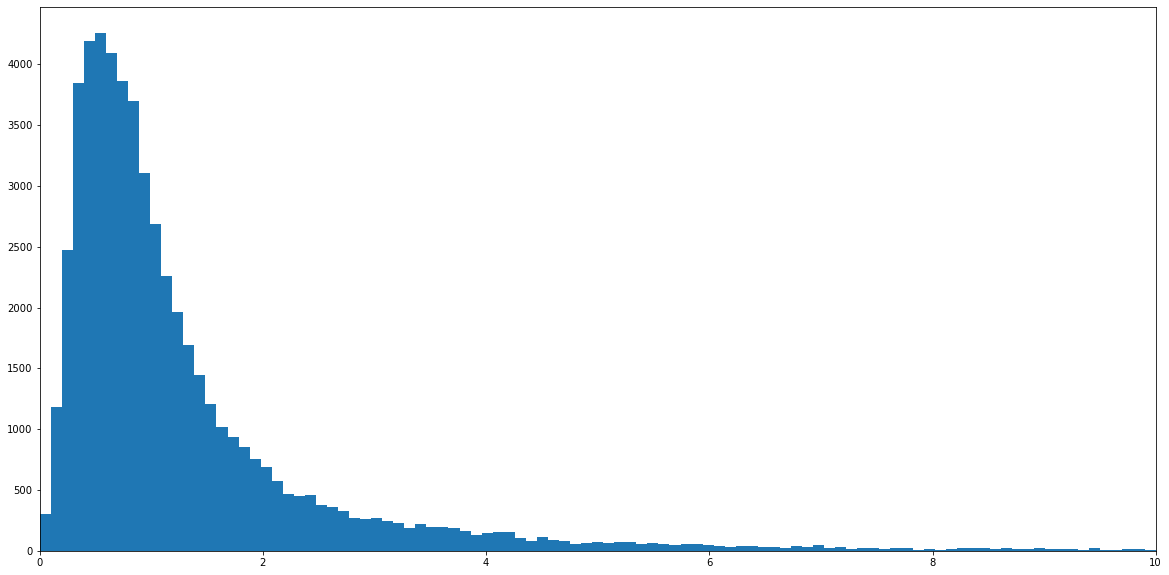

In [44]:
plt.figure(figsize = (20, 10))
plt.hist(np.sort(thing)[:-np.isinf(thing).sum()], bins = 1000)

#plt.hist(np.sort(thing), bins = 1000)
plt.xlim(0, 10)


In [45]:
b = df["Class_multi_40_20"].values
((b== 0).sum() + (b == 1).sum() + (b == 2).sum() + (b == 3).sum()) / ((b== 19).sum() + (b == 18).sum() + (b == 17).sum() + (b == 16).sum())

0.8201759600523124

In [35]:
[np.nanmean(np.reshape(thing, (-1, 13))[:,j][int(length / 4): int(length * 3 / 4)]) for j in range(13)]

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]

In [47]:

length = len(np.reshape(thing, (-1, 13))[:,0])

In [48]:

[np.mean(np.sort(np.reshape(thing, (-1, 13))[:-(np.isinf(np.reshape(thing, (-1, 13))[:,j]).sum()),j])[int(length / 4): int(length * 3 / 4)]) for j in range(13)]

[0.886996492906071,
 0.9024725471837541,
 0.9095405961597866,
 0.9145637693509027,
 0.9197399632681855,
 0.9248408526137776,
 0.9276265195887213,
 0.9312654229574753,
 0.9324494009302379,
 0.9331280764224191,
 0.9334172755491277,
 0.9347391764624009,
 0.9352928086293587]

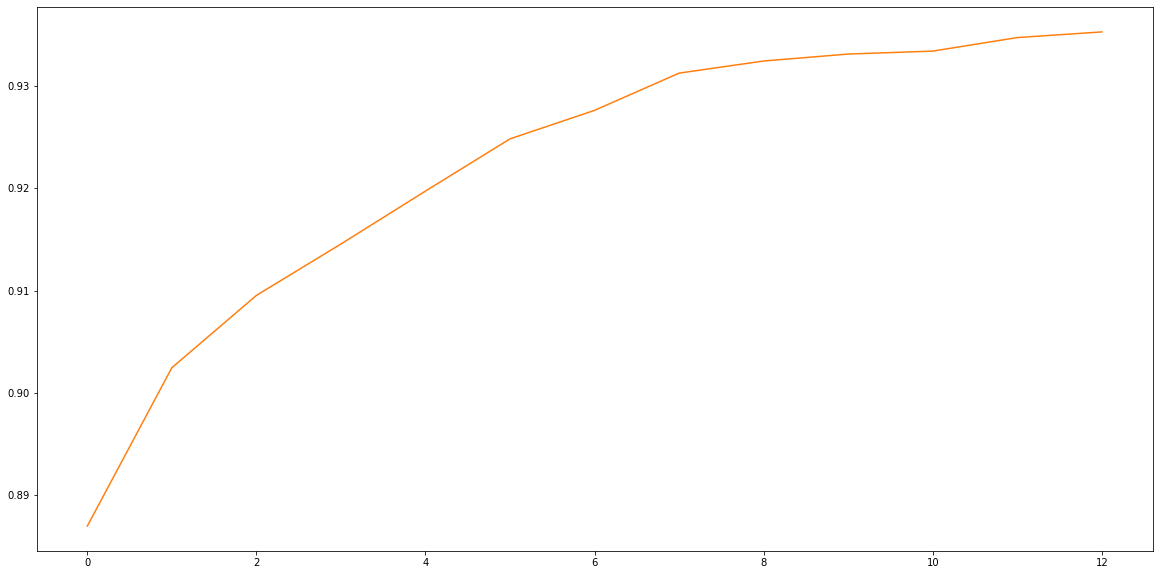

In [49]:
plt.figure(figsize = (20, 10))
plt.plot(np.mean(np.reshape(thing, (-1, 13)), axis = 0))
#plt.plot(np.median(np.reshape(thing, (-1, 13)), axis = 0))

length = len(np.reshape(thing, (-1, 13))[:,0])
plt.plot([np.mean(np.sort(np.reshape(thing, (-1, 13))[:-(np.isinf(np.reshape(thing, (-1, 13))[:,j]).sum()),j])[int(length / 4): int(length * 3 / 4)]) for j in range(13)])
#plt.plot([np.mean(np.sort(np.reshape(thing, (-1, 13))[:,j])[:-np.isinf(np.reshape(thing, (-1, 13))[:,j]).sum()]) for j in range(13)])

In [ ]:
np.mean(np.reshape(thing_1, (-1, 13))[:])[int(length / 4): int(length * 3 / 4)]) for j in range(13)

In [ ]:
[np.mean(np.sort(np.reshape(thing, (-1,13))[:,j])[int(length / 4) : int(length * 3 / 4)]) for j in range(13)]

In [56]:
[np.mean(np.sort(np.reshape(thing_1, (-1,13))[:,j])[:-(np.isinf(np.reshape(thing_1, (-1, 13))[:,j]).sum())][int(length / 4): int(length * 3 / 4)]) for j in range(13)]

[0.8863554265903449,
 0.901839369080529,
 0.9093849728755979,
 0.9144053920902915,
 0.9192312055891886,
 0.9241751199478226,
 0.9271719351140494,
 0.9308089646719465,
 0.9324239145754208,
 0.9326379267485809,
 0.9333177007502541,
 0.9346562323284653,
 0.9352260464613524]

In [88]:
[(np.reshape(thing, (-1, 13))[:,j] > 0).sum() / length * 100 for j in range(13)]

[61.15702479338842,
 60.968122786304605,
 61.20425029515939,
 61.98347107438017,
 62.2668240850059,
 62.33766233766234,
 62.52656434474616,
 62.64462809917355,
 62.52656434474616,
 62.76269185360095,
 62.69185360094451,
 62.71546635182999,
 62.76269185360095]

In [92]:
[(np.reshape(thing, (-1, 13))[:,j][int(length / 5): int(length / 5 * 4)] > 0).sum() / (length * 0.6) * 100 for j in range(13)]

[61.471861471861466,
 61.471861471861466,
 61.66863439590712,
 62.022825659189294,
 61.82605273514364,
 62.18024399842582,
 62.53443526170799,
 62.573789846517116,
 62.573789846517116,
 62.77056277056276,
 63.08539944903582,
 62.92798110979929,
 63.04604486422668]

In [94]:
(df["return_40"] > 0).sum() / len(df) * 100

46.98613802355045

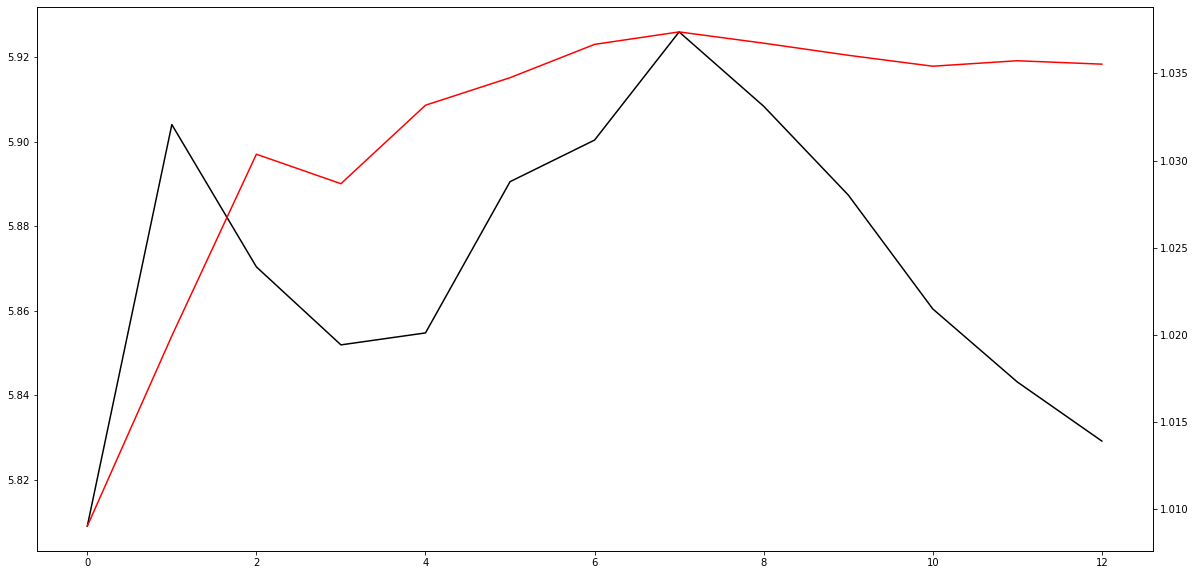

In [97]:

length = len(np.reshape(thing, (-1, 13))[:,0])


"""
mid 50
"""
#left_data = [np.mean(np.sort(np.reshape(thing, (-1,13))[:,j])[int(length / 4): int(length *3 / 4)]) for j in range(13)]
#right_data = [np.mean(np.sort(np.reshape(thing_1, (-1,13))[:,j])[:-(np.isinf(np.reshape(thing_1, (-1, 13))[:,j]).sum())][int(length / 4): int(length *3 / 4)]) for j in range(13)]


"""
mid 90
"""
#left_data = [np.mean(np.sort(np.reshape(thing, (-1,13))[:,j])[int(length / 10) : int(length * 9 / 10)]) for j in range(13)]
#right_data = [np.mean(np.sort(np.reshape(thing_1, (-1,13))[:,j])[:-(np.isinf(np.reshape(thing_1, (-1, 13))[:,j]).sum())][int(length / 10): int(length * 9 / 10)]) for j in range(13)]


"""
whole
"""
#left_data = [np.mean(np.reshape(thing, (-1, 13))[:,j]) for j in range(13)]
#right_data = [np.mean(np.sort(np.reshape(thing_1, (-1,13))[:,j])[:-(np.isinf(np.reshape(thing_1, (-1, 13))[:,j]).sum())]) for j in range(13)]

"""
num return days > 0
"""

#left_data = [(np.reshape(thing, (-1, 13))[:,j] > 0).sum() / length * 100 for j in range(13)]
#right_data = [(np.reshape(thing, (-1, 13))[:,j][int(length / 5): int(length / 5 * 4)] > 0).sum() / (length * 0.6) * 100 for j in range(13)]




fig, ax_left = plt.subplots(figsize = (20, 10))
ax_right = ax_left.twinx()

ax_left.plot(left_data, color='black')
ax_right.plot(right_data, color='red')



In [ ]:
"""
want returns vs prediction_date
"""

In [98]:
dates_dict = {}

for i in results:
    
    thing_to_append = np.mean(np.array(i[4])[:,0])
    indx = np.where(Datesog == i[0])[0][0]
    
    try:
        
        dates_dict[indx].append(thing_to_append)
        
    except:
        
        dates_dict[indx] = [thing_to_append]
        
        

In [99]:
dates_dict_data = {}

for i in np.sort(list(dates_dict.keys())):
    
    dates_dict_data[i] = [np.mean(dates_dict[i]), np.std(dates_dict[i]), len(dates_dict[i])]

In [74]:
sp500 = pd.read_pickle("External_data/sp500")

In [75]:
sp500

,Volume,Open,High,Low,Close,return_40
Date,,,,,,
2012-01-04,--,1277.03,1278.73,1268.10,1277.30,6.919283
2012-01-05,--,1277.30,1283.05,1265.26,1281.06,7.261955
2012-01-06,--,1280.93,1281.84,1273.34,1277.81,7.185732
2012-01-09,--,1277.83,1281.99,1274.55,1280.70,6.530023
2012-01-10,--,1280.77,1296.46,1280.77,1292.08,3.968795
...,...,...,...,...,...,...
2021-12-28,--,4795.49,4807.02,4780.04,4786.35,NaN
2021-12-29,--,4788.64,4804.06,4778.08,4793.06,NaN
2021-12-30,--,4794.23,4808.93,4775.33,4778.73,NaN


In [81]:
sp500 = sp500.loc[Datesog[np.sort(list(dates_dict.keys()))]]["return_40"].values

In [82]:
np.sort(list(dates_dict.keys()))

array([ 762,  763,  764, ..., 2230, 2231, 2232], dtype=int64)

In [ ]:
plt.figure(figsize = (20, 10))

plt.plot(np.sort(list(dates_dict.keys())), np.reshape(list(dates_dict_data.values()), (-1, 3))[:,0])
plt.plot(np.sort(list(dates_dict.keys())), sp500)


In [102]:
results[0][2]

69518

In [106]:
size_dict = {}

for i in results:
    
    thing_to_append = np.mean(np.array(i[4])[:,0])
    
    indx = i[2]
    
    try:
        
        size_dict[indx].append(thing_to_append)
        
    except:
        
        size_dict[indx] = [thing_to_append]

In [109]:
size_dict_data = {}

for i in np.sort(list(size_dict.keys())):
    
    size_dict_data[i] = [np.mean(size_dict[i]), np.std(size_dict[i]), len(size_dict[i])]
    
    

In [ ]:
np.sort(list(size_dict.keys()))

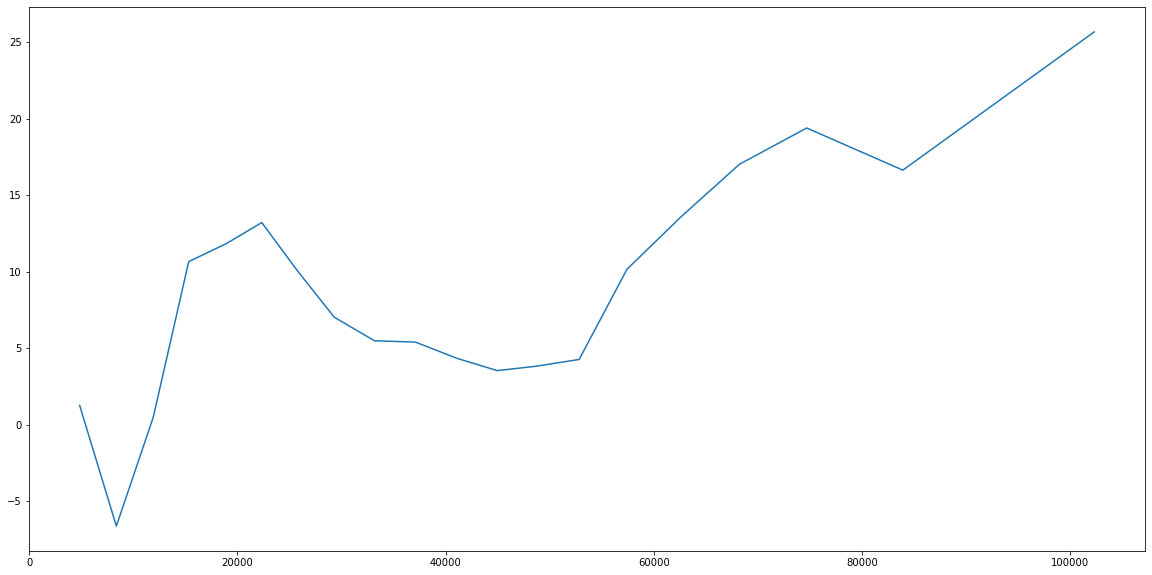

In [117]:
"""
vs training days, notice it might be biased because alot of good returns were incurred near the final pred days, meaning that the traininng sets were longer by default
"""
plt.figure(figsize = (20, 10))

plt.plot([np.mean(np.array_split(np.sort(list(size_dict.keys())), 20)[j]) for j in range(20)], [np.mean(np.array_split(np.reshape(list(size_dict_data.values()), (-1, 3))[:,0], 20)[j]) for j in range(20)])



In [ ]:
"""
one for raw results, on first boosting round,and on last boosting round
one for ratio good / bad on first and last boosting roubnd

on boosting round
"""

In [271]:
len(results[0][1])

15

In [272]:
col_size_dict = {}

for i in results:
    
    thing_to_append = np.mean(np.array(i[4])[:,0])
    
    indx = len(i[1])
    
    try:
        
        col_size_dict[indx].append(thing_to_append)
        
    except:
        
        col_size_dict[indx] = [thing_to_append]

In [273]:
col_size_dict_data = {}

for i in np.sort(list(col_size_dict.keys())):
    
    col_size_dict_data[i] = [np.mean(col_size_dict[i]), np.std(col_size_dict[i]), len(col_size_dict[i])]
    
    

In [276]:
list(col_size_dict_data.keys()), np.array(list(col_size_dict_data.values()))[:,0]

([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 array([ 9.43007674,  7.99866483,  7.50309417, 12.43768032, 10.20742039,
        10.95183253,  9.92715157,  9.23588758,  7.77367215,  7.50395145,
         5.31549479,  8.68254686,  8.27250936,  8.86297632,  9.0119911 ,
         8.63387231,  6.404593  ,  9.80954666, 11.19022475]))

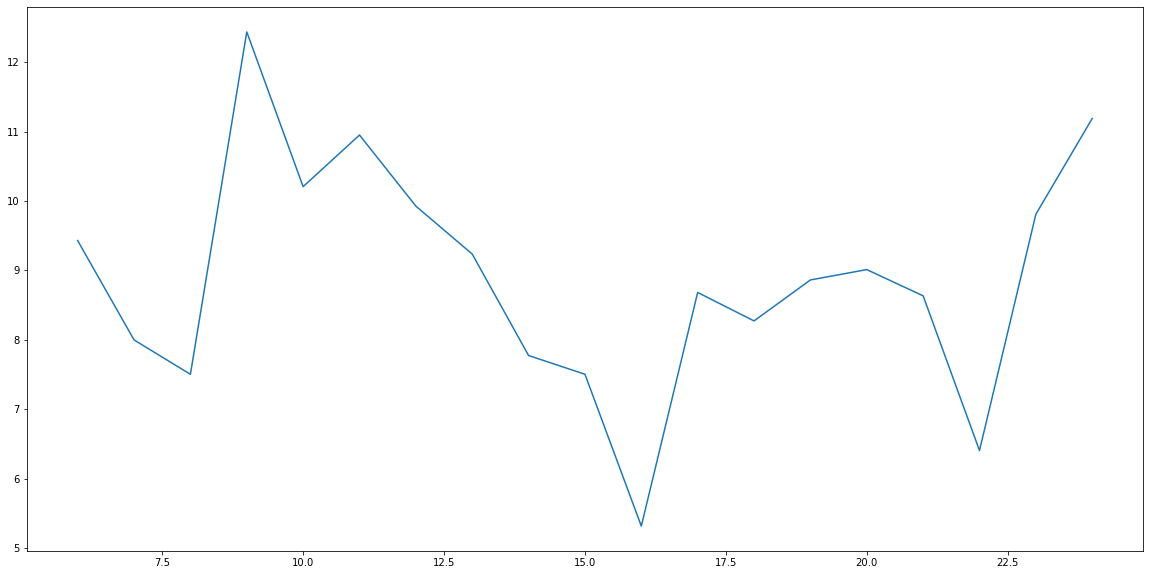

In [277]:
plt.figure(figsize = (20,10))
plt.plot(list(col_size_dict_data.keys()), np.array(list(col_size_dict_data.values()))[:,0])

In [121]:
results_dict_0 = {}
results_dict_last = {}
results_dict_ratio_0 = {}
results_dict_ratio_last = {}


for i in results:
    
    
    
    for col_name in i[1]:
        
        thing_to_append =  i[4][0][0]
        
        try:
                results_dict_0[col_name].append(thing_to_append)
                
        except:
            results_dict_0[col_name] = [thing_to_append]
            
            
        thing_to_append =  i[4][-1][0]
        
        try:
                results_dict_last[col_name].append(thing_to_append)
                
        except:
            results_dict_last[col_name] = [thing_to_append]
            
        thing_to_append =  i[4][0][1]
        
        try:
                results_dict_ratio_0[col_name].append(thing_to_append)
                
        except:
            results_dict_ratio_0[col_name] = [thing_to_append]
            
        thing_to_append =  i[4][-1][1]
        
        try:
                results_dict_ratio_last[col_name].append(thing_to_append)
                
        except:
            results_dict_ratio_last[col_name] = [thing_to_append]
            


In [243]:
results_dict_0_data = {}
results_dict_last_data = {}
results_dict_ratio_0_data = {}
results_dict_ratio_last_data = {}


for col_name, data in results_dict_0.items():
    results_dict_0_data[col_name] = [np.mean(data), (np.array(data) > 0).sum() / len(data), np.std(data), len(data)]

for col_name, data in results_dict_last.items():
    results_dict_last_data[col_name] = [np.mean(data), (np.array(data) > 0).sum() / len(data), np.std(data), len(data)]
    
for col_name, data in results_dict_ratio_0.items():
    
    if np.isinf(np.array(data)).sum():
        
        data = np.sort(data)[:-np.isinf(np.array(data)).sum()]
        
    results_dict_ratio_0_data[col_name] = [np.mean(data), (np.array(data) > 1).sum() / len(data), np.std(data), len(data)]
    
for col_name, data in results_dict_ratio_last.items():
    if np.isinf(np.array(data)).sum():
        
        data = np.sort(data)[:-np.isinf(np.array(data)).sum()]
        
    results_dict_ratio_last_data[col_name] = [np.mean(data), (np.array(data) > 1).sum() / len(data), np.std(data), len(data)]


In [158]:
len(np.array(list(dataset.keys())))

290

In [162]:
"""
by random chance mean number of same columns in choosing from 290
"""
np.mean(test)

5.5183

In [179]:
np.array(list(dataset.values()))[col_indx, 0][-40:]

array([10.68389279, 10.69756325, 10.70624784, 10.75424215, 10.80852839,
       10.84173526, 10.84861687, 10.97501149, 10.97565796, 11.08393002,
       11.10529824, 11.13655054, 11.19799547, 11.21462575, 11.22704516,
       11.25620119, 11.38676292, 11.42036516, 11.46054393, 11.6337496 ,
       11.64096132, 11.65046394, 11.69093552, 11.71059447, 11.76089873,
       11.94471854, 11.954421  , 12.07748904, 12.17880974, 12.18222007,
       12.24208844, 12.32223996, 12.36293179, 12.37566788, 12.42915797,
       12.60758874, 12.65980121, 12.73726531, 14.39937067, 15.62555659])

In [264]:
results_df.to_pickle("TrainingSecondDataset/results_df")

In [265]:
results_test = pd.read_pickle("TrainingSecondDataset/results_df")

In [194]:
results_df = pd.DataFrame(["results_dict_last_data", "return_sort", top_40_last, np.mean(np.array(list(dataset.values()))[col_indx, 0][-40:]), np.mean(np.array(list(dataset.values()))[col_indx, 1][-40:])])

In [222]:
np.isinf(np.array(list(results_dict_ratio_0_data.values()))[:,0]).sum()

75

In [ ]:
results_dict_ratio_0_data

In [262]:

dataset = results_dict_ratio_last_data
col_indx = np.argsort(np.array(list(dataset.values()))[:,1])

top_40_last = np.array(list(dataset.keys()))[col_indx][-40:]

columns_ordered = np.array(list(dataset.keys()))[col_indx]

#print(np.mean(np.array(list(dataset.values()))[col_indx, 0][-40:]))

#print(np.mean(np.array(list(dataset.values()))[col_indx, 1][-40:]))

print(np.mean([(results_dict_0_data[j][0]) for j in top_40_last]))
print(np.mean([(results_dict_0_data[j][1]) for j in top_40_last]))



10.352620584795437
0.6334709827495699


In [ ]:
np.mean([(results_dict_0_data[j][1]) for j in top_40_last])

In [263]:
results_df[8] = (["results_dict_ratio_last_data", ">1_sort", top_40_last, columns_ordered, np.mean([(results_dict_0_data[j][0]) for j in top_40_last]), np.mean([(results_dict_0_data[j][1]) for j in top_40_last])])

In [214]:
results_df[4] = (["results_dict_ratio_0_data", "return_sort", top_40_last, columns_ordered, np.mean(np.array(list(dataset.values()))[col_indx, 0][-40:]), np.mean(np.array(list(dataset.values()))[col_indx, 1][-40:])])

In [217]:
results_df[3] = (["results_dict_last_data", "percent_pos_sort", top_40_last, columns_ordered, np.mean(np.array(list(dataset.values()))[col_indx, 0][-40:]), np.mean(np.array(list(dataset.values()))[col_indx, 1][-40:])])

In [ ]:
pd.concat()

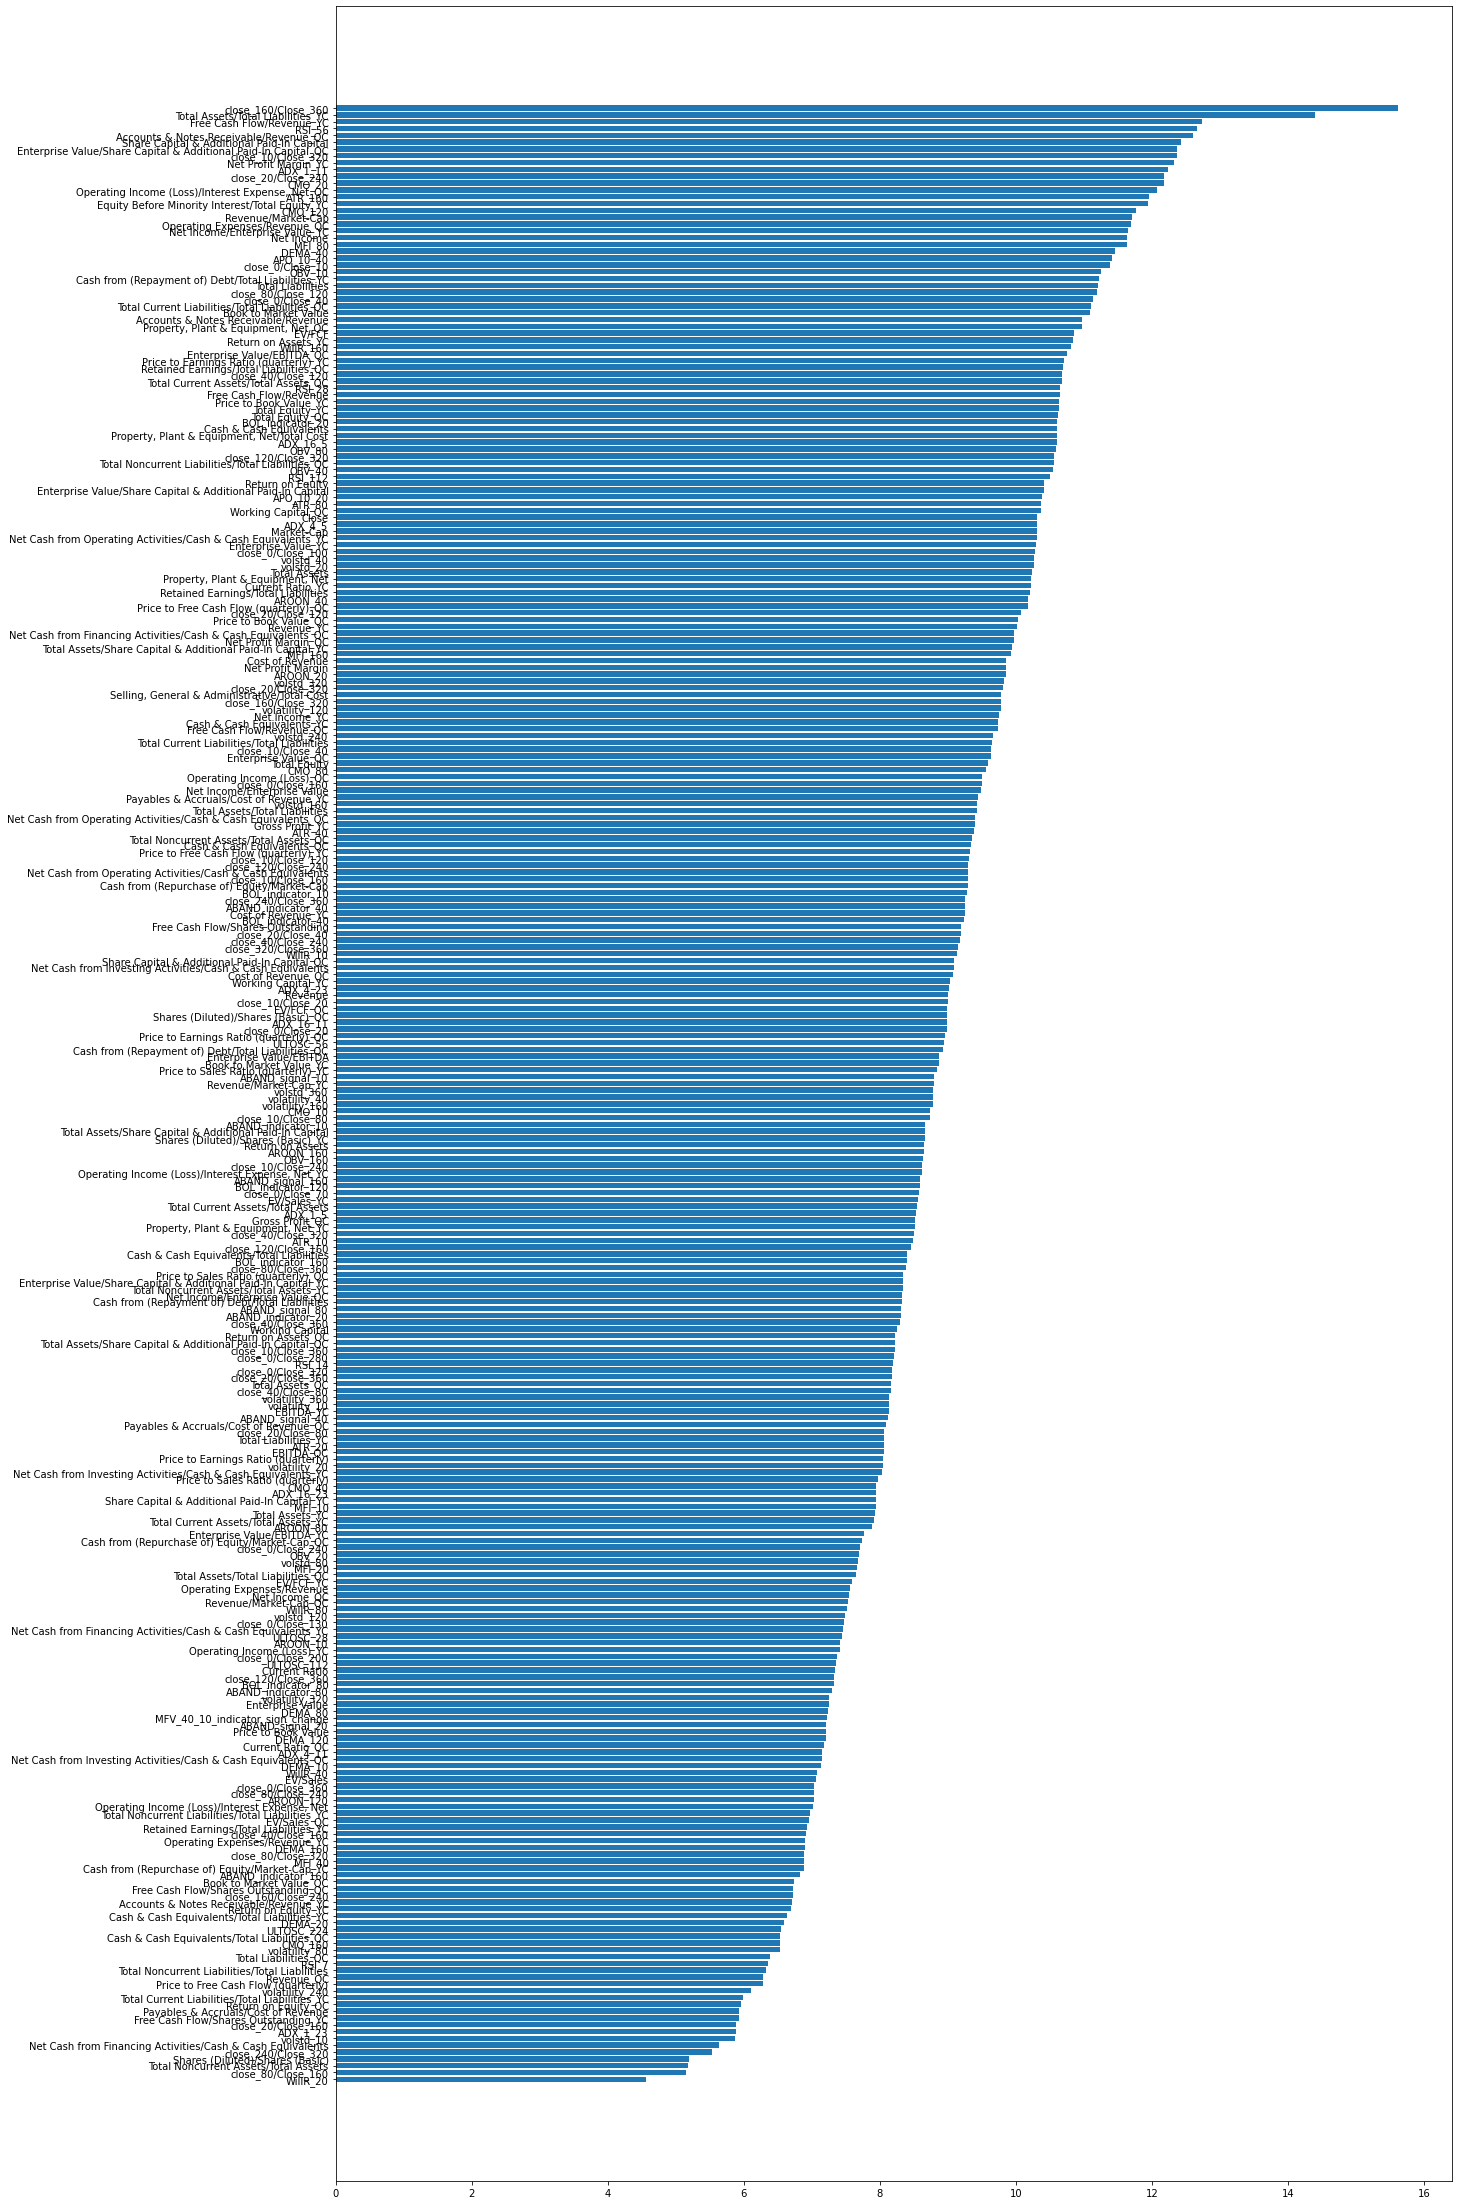

In [177]:
dataset = results_dict_0_data
col_indx = np.argsort(np.array(list(dataset.values()))[:,0])
plt.figure(figsize = (20,40))
plt.barh(np.array(list(dataset.keys()))[col_indx], np.array(list(dataset.values()))[col_indx, 0])
top_40_0 = np.array(list(dataset.keys()))[col_indx][-40:]

In [282]:
df.loc[Dates[200:220]]

Close  ABAND_indicator_10  ABAND_indicator_20  \
Date       Ticker                                                  
2015-09-18 IPDN     6.08           -0.161305           -0.152416   
           LEE     18.30            0.105278           -0.086890   
           OTRK     4.71           -0.357043           -0.428015   
           SORL     1.83           -0.225029           -0.194249   
           IO       7.84           -0.007705            0.004968   
...                  ...                 ...                 ...   
2015-10-15 LIVE     9.36           -0.212223           -0.241855   
           TLYS     7.87            0.016348            0.130133   
           RGLS    86.40            0.197827            0.012462   
           ONVO    65.60            0.173948            0.028137   
           GIMO    21.40            0.184057            0.015811   

                   ABAND_indicator_40  ABAND_signal_10  ABAND_signal_20  \
Date       Ticker                                                         
2015-09-18 IPDN             -0.544516              0.0              0.0   
           LEE              -0.679426              0.0              0.0   
           OTRK             -0.793228              0.0             -1.0   
           SORL             -0.526838              0.0              0.0   
           IO               -0.285001              0.0              0.0   
...                               ...              ...              ...   
2015-10-15 LIVE             -0.178127              0.0              0.0   
           TLYS              0.009727              0.0              0.0   
           RGLS             -0.155423              0.0              0.0   
           ONVO              0.214131              0.0              0.0   
           GIMO             -0.151972              0.0              0.0   

                   ABAND_signal_40  MFV_40_10_indicator_sign_change  \
Date       Ticker                                                     
2015-09-18 IPDN               -1.0                              0.0   
           LEE                -1.0                              0.0   
           OTRK               -1.0                              0.0   
           SORL               -1.0                              0.0   
           IO                  0.0                              0.0   
...                            ...                              ...   
2015-10-15 LIVE                0.0                              0.0   
           TLYS                0.0                              0.0   
           RGLS                0.0                              0.0   
           ONVO                0.0                              1.0   
           GIMO                0.0                              0.0   

                   APO_10_20  APO_10_40  ...  return_40  Class_multi_40_20  \
Date       Ticker                        ...                                 
2015-09-18 IPDN    -0.098041  -0.316053  ... -14.473684               15.0   
           LEE     -0.070854  -0.192140  ...  -4.918033               12.0   
           OTRK    -0.102850  -0.221963  ... -50.955414               19.0   
           SORL    -0.032308  -0.125586  ...  31.693989                0.0   
           IO      -0.038814  -0.196182  ... -36.607143               19.0   
...                      ...        ...  ...        ...                ...   
2015-10-15 LIVE    -0.015207  -0.056495  ...  37.820513                0.0   
           TLYS     0.000885  -0.028250  ... -22.363405               17.0   
           RGLS    -0.042924  -0.107462  ...  14.861111                1.0   
           ONVO     0.008864   0.004622  ... -14.634146               15.0   
           GIMO    -0.024692  -0.081519  ...  21.915888                0.0   

                   Class_binary_20_20  return_20  Class_binary_10_20  \
Date       Ticker                                                      
2015-09-18 IPDN                   1.0 -34.210526                 1.0   
   

In [285]:
(df.loc[Dates[:160]]["Class_binary_40_20"] == 0).sum() / len(df.loc[Dates[:160]]["Class_binary_40_20"])

0.1476944019057342

In [286]:
(df["Class_binary_40_20"] == 0).sum() / len(df)

0.15862274556565806

In [287]:
len(df)

134180

In [290]:
len(df) / len(Dates) * 20 * 0.16

352.5254515599343

In [292]:
80000 / 300

266.6666666666667